In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from astropy.io import fits
import dill as pickle
from emcee import EnsembleSampler
import numpy as np
import os
import sys

pwd = os.getcwd()
little_things_root_dir = os.path.dirname(os.path.dirname(pwd))
sys.path.append(little_things_root_dir)

from little_things_lib.galaxy import Galaxy
from little_things_lib.nfw_mcmc_fitter import (
    EmceeParameters,
    get_mcmc_start_position, 
    generate_nwalkers_start_points, 
    lnprob)
from little_things_lib.plotting import plot_posterior_distributions, plot_walker_paths
from datetime import datetime


RAD_PER_ARCSEC = np.pi / (60*60*180)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Enter parameters for galaxy in cell below

In [3]:
galaxy_name = 'NGC2366'

velocity_error_2d = 10  # [km/s]

DEG_PER_PIXEL = 4.17e-4
DISTANCE = 3400 # kpc

# can leave these as any number for now, not used
LUMINOSITY = 1e8  # solar luminositiy
HI_MASS = 1e8  # solar masses

In [4]:
mcmc_params = EmceeParameters(
    ndim=3,
    nwalkers=10, 
    nburn=400,
    niter=1000,
    nthin=5,
    nthreads=4
)


In [5]:
"""
Expect the data to be provided in following naming convention in 'data' directory:

2D observed velocity field FITS file: <galaxy_name>_1mom.fits
Bbarolo fit parameters text file: <galaxy_name>_ring_parameters.txt
Stellar velocity curve: <galaxy_name>_stellar_velocities.txt
Gas velocity_curve: <galaxy_name>_gas_velocities.txt

"""


data_dir = os.path.join(little_things_root_dir, 'data')

observed_2d_vel_field_fits_file = os.path.join(data_dir, f'{galaxy_name}_1mom.fits')
ring_parameters_file = os.path.join(data_dir, f'{galaxy_name}_ring_parameters.txt')

stellar_velocities_file = os.path.join(data_dir, f'{galaxy_name}_stellar_velocities.txt')
gas_velocities_file = os.path.join(data_dir, f'{galaxy_name}_gas_velocities.txt')


In [6]:
radii_arcsec, test_rotation_curve, inclinations, position_angles, x_centers, y_centers , v_systemics = \
    np.loadtxt(ring_parameters_file, usecols=(1,2,4,5,-4,-3,-2)).T

radii_kpc = radii_arcsec * RAD_PER_ARCSEC * DISTANCE
avg_inclination = np.mean(inclinations)
avg_position_angle = np.mean(position_angles)
avg_x_center = 290
avg_y_center = 290
x_centers = np.array([avg_x_center for i in range(len(inclinations))])
y_centers = np.array([avg_y_center for i in range(len(inclinations))])
v_systemic = np.mean(v_systemics)

observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data

stellar_radii, stellar_vel = np.loadtxt(stellar_velocities_file, unpack=True, usecols =(0,1))
gas_radii, gas_vel = np.loadtxt(gas_velocities_file, unpack=True, usecols = (0,1))

In [7]:
galaxy = Galaxy(
    distance_to_galaxy=DISTANCE,  # [kpc] Look this up for the galaxy 
    deg_per_pixel=DEG_PER_PIXEL ,  # 'CRDELT1' and 'CRDELT2' in the FITS file header (use absolute value)
    galaxy_name=galaxy_name,
    vlos_2d_data=observed_2d_vel_field,
    v_error_2d=velocity_error_2d,
    output_dir='output',
    luminosity=LUMINOSITY,
    HI_mass=HI_MASS)

tilted_ring_params = {
    'v_systemic': v_systemic,
    'radii': radii_kpc,   
    'inclination': inclinations,
    'position_angle': position_angles,
    'x_pix_center': x_centers,
    'y_pix_center': y_centers
}

galaxy.set_tilted_ring_parameters(**tilted_ring_params)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='stellar',
    rotation_curve_radii=stellar_radii,
    rotation_curve_velocities=stellar_vel)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='gas',
    rotation_curve_radii=gas_radii,
    rotation_curve_velocities=gas_vel)

# initialize MCMC start position and bounds
galaxy.set_nfw_prior_bounds(
    rhos_bounds=(1e4, 1e10),   # msun / kpc^3
    rs_bounds=(0.1, 200),  # kpc
    ml_bounds=(0.1, 2),
  
)

In [8]:
# This will print warnings if the start points go outside prior bounds

start_point, start_point_radii = get_mcmc_start_position(galaxy)
start_pos = generate_nwalkers_start_points(galaxy, mcmc_params.nwalkers, start_point, start_point_radii)

In [9]:
# initialize sampler
sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)

# burn in 
sampler.run_mcmc(start_pos, N=mcmc_params.nburn)
start_pos_after_burn_in = sampler._last_run_mcmc_result[0]
sampler.reset()

In [10]:
sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)

# this will break up the fitting procedure into smaller chunks of size batch_size and save progress
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y")

batch_size = 20
mcmc_output = []
for batch in range(mcmc_params.niter // batch_size):
    if batch == 0:
        batch_start = start_pos_after_burn_in
    else:
        batch_start = None
        sampler.pool = temp_pool
    mcmc_output += sampler.run_mcmc(batch_start, batch_size, thin=mcmc_params.nthin)
    temp_pool = sampler.pool
    del sampler.pool
    with open(f'sampler_{timestampStr}.pkl', 'wb') as f:
        pickle.dump(sampler, f)
    with open(f'mcmc_output_{timestampStr}.pkl', 'wb') as f:
        pickle.dump(mcmc_output, f)
    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_params.niter}")


Done with steps 0 - 20 out of 1000
Done with steps 20 - 40 out of 1000
Done with steps 40 - 60 out of 1000
Done with steps 60 - 80 out of 1000
Done with steps 80 - 100 out of 1000
Done with steps 100 - 120 out of 1000
Done with steps 120 - 140 out of 1000
Done with steps 140 - 160 out of 1000
Done with steps 160 - 180 out of 1000
Done with steps 180 - 200 out of 1000
Done with steps 200 - 220 out of 1000
Done with steps 220 - 240 out of 1000
Done with steps 240 - 260 out of 1000
Done with steps 260 - 280 out of 1000
Done with steps 280 - 300 out of 1000
Done with steps 300 - 320 out of 1000
Done with steps 320 - 340 out of 1000
Done with steps 340 - 360 out of 1000
Done with steps 360 - 380 out of 1000
Done with steps 380 - 400 out of 1000
Done with steps 400 - 420 out of 1000
Done with steps 420 - 440 out of 1000
Done with steps 440 - 460 out of 1000
Done with steps 460 - 480 out of 1000
Done with steps 480 - 500 out of 1000
Done with steps 500 - 520 out of 1000
Done with steps 520 - 

#### The two cells below demonstrate how to load your saved results. This is useful in the follow cases:

1) You finished a long MCMC fitting run and want to plot the results without having to redo the whole thing.

2) Your computer crashed before it was done running the previous MCMC fit and you want to restart it from the last saved iteration. In this case you can run the second cell below to continue the MCMC fitting. The results of the restarted run will be saved separately from the results of the previous run. The combined results will also be saved.

In [11]:
# example of how to load the pickled objects
# change the name of the files to whatever yours were saved as

with open(f'sampler_{timestampStr}.pkl', 'rb') as f:
    saved_sampler = pickle.load(f)
    restart_pos = saved_sampler._last_run_mcmc_result[0]
with open(f'mcmc_output_{timestampStr}.pkl', 'rb') as f:
    saved_mcmc_output = pickle.load(f)

In [12]:
# example of how to restart the MCMC fit from the last save point 
# assumes you loaded the sampler and mcmc_output from the saved pickles in the example above

restart_sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)
restart_mcmc_output = []

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y")

batch_size = 10
for batch in range(mcmc_params.niter // batch_size):
    if batch==0:
        batch_start = restart_pos
    else:
        batch_start = None
        restart_sampler.pool = temp_pool
    restart_mcmc_output += restart_sampler.run_mcmc(batch_start, batch_size, thin=mcmc_params.nthin)
    temp_pool = restart_sampler.pool
    del sampler.pool
    with open(f'sampler_{timestampStr}.pkl', 'wb') as f:
        pickle.dump(restart_sampler, f)
    with open(f'mcmc_output_{timestampStr}.pkl', 'wb') as f:
        pickle.dump(restart_mcmc_output, f)
    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_params.niter}")

    
# this step adds the MCMC results from the restarted run to the ones that were saved from the previous run.
total_mcmc_output = saved_mcmc_output + restart_mcmc_output
with open(f'total_mcmc_output_{timestampStr}.pkl', 'wb') as f:
    pickle.dump(total_mcmc_output, f)

KeyboardInterrupt: 

#### Plot the posterior distributions and walker paths

In [13]:
sampler=saved_sampler

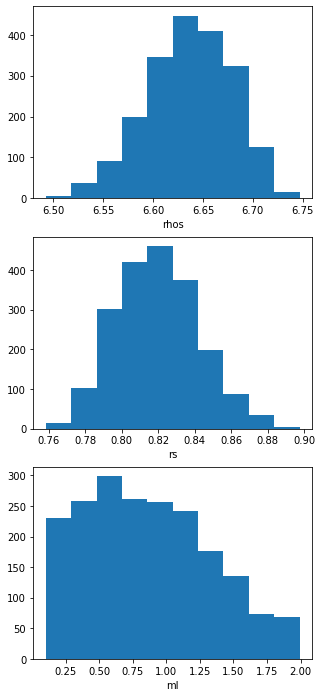

rhos: 6.635856578503603 +/- 0.042508530706976924
rs: 0.8195301904975689 +/- 0.022323627313668236
ml: 0.8642182722897768 +/- 0.4645783913819555


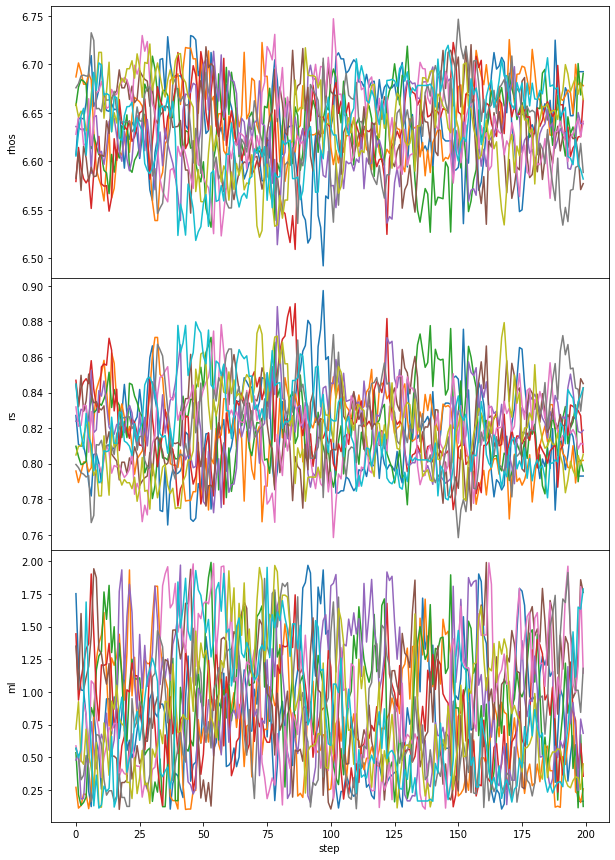

In [14]:
plot_posterior_distributions(sampler, labels=['rhos', 'rs', 'ml'])

plot_walker_paths(
    sampler,
    mcmc_params,
    labels=['rhos', 'rs', 'ml'])

def get_fit_stats(sampler, labels=["rhos", "rs", "ml"]):
    for i, label in enumerate(labels):
        chain = sampler.chain[:, :, i].flatten()
        print(f"{label}: {np.mean(chain)} +/- {np.std(chain)}")
        
get_fit_stats(sampler)

#### Compare observed 2d velocity field with one generated during fitting process

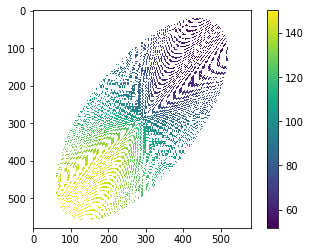

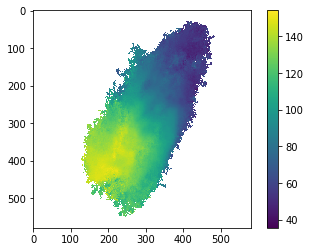

In [15]:
example_2d_field = saved_mcmc_output[-1][9][-1]
plt.imshow(example_2d_field)
plt.colorbar()
plt.show()

plt.imshow(galaxy.vlos_2d_data)
plt.colorbar()
plt.show()


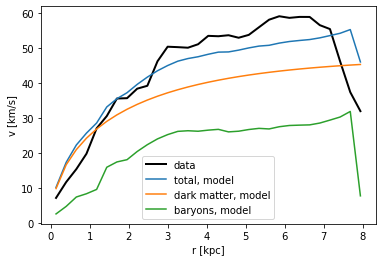

In [16]:
#blobs = np.reshape(sampler.blobs, (int(mcmc_params.niter/mcmc_params.nthin) * mcmc_params.nwalkers, 10))
blobs = [] 
for subarr in sampler.blobs:
    blobs += subarr
blobs = np.array(blobs)
v_dm = np.mean(blobs[:, 4])
v_baryon = np.mean( blobs[:, 5])
v_tot = np.mean( blobs[:, 7])

plt.plot(radii_kpc, test_rotation_curve, linewidth=2., label="data", color="black")

plt.plot(galaxy.radii, v_tot, label="total, model")
plt.plot(galaxy.radii, v_dm, label="dark matter, model")
plt.plot(galaxy.radii, v_baryon, label="baryons, model")
plt.xlabel("r [kpc]")
plt.ylabel("v [km/s]")
plt.legend()